[NLP course](https://lena-voita.github.io/nlp_course)

In [ ]:
!pip install bokeh nltk gensim spacy umap-learn 

In [9]:
import bidict
import bokeh
import bokeh.models
import bokeh.plotting
import collections
import dataclasses
import functools
import IPython
import itertools
import gensim
import gensim.downloader
import nltk
import numpy as np
import pandas as pd
import pprint
import random
import requests
import sklearn.manifold
import sklearn.pipeline
import smart_open
import spacy
import string
import umap

bokeh.io.output_notebook()

Loading BokehJS ...

In [38]:
def batched(iterable, n):
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(itertools.islice(it, n)):
        yield batch
        
@functools.cache
def cache_read(path) -> str:
    return smart_open.open(path).read()


def embed(
    vectors: np.ndarray, model: str = "tsne", n_components: int = 2
) -> np.ndarray:
    match model:
        case "tsne":
            pipeline = [sklearn.manifold.TSNE(n_components=n_components)]
        case "umap":
            pipeline = [
                sklearn.preprocessing.StandardScaler(),
                umap.UMAP(n_components=n_components),
            ]

    pipeline = sklearn.pipeline.Pipeline(
        [(str(i), step) for i, step in enumerate(pipeline)]
    )
    embedding = pipeline.fit_transform(vectors)
    return embedding

def plot_with_annotations(x, y, annotations, title=None):
    data = {"x": x, "y": y, "annotation": annotations}

    figure = bokeh.plotting.figure(title=title, tooltips=[("", "@annotation",)])
    figure.scatter("x", "y", source=data)

    bokeh.plotting.show(figure)

In [2]:
@dataclasses.dataclass
class Config:
    doc_name: str = "dracula"
    doc_path: str = "https://www.gutenberg.org/cache/epub/345/pg345.txt"

In [3]:
def get_universal_tag(word: str) -> str:
    return nltk.tag.pos_tag([word], tagset="universal")[0][1]

def get_universal_tagset() -> bidict.bidict[str, str]:
    return bidict.bidict({
        "ADJ": "adjective",
        "ADP": "adposition",
        "ADV": "adverb",
        "CONJ": "conjunction",
        "DET": "determiner,",
        "NOUN": "noun",
        "NUM": "numeral",
        "PRT": "particle",
        "PRON": "pronoun",
        "VERB": "verb",
        ".": "punctuation",
        "X": "other",
    })

## NLTK

In [67]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = text.translate({ord(p): None for p in string.punctuation})
    return text


def tokenize(text: str) -> list[str]:
    tokenize = nltk.tokenize.RegexpTokenizer("\w+").tokenize
    to_lower = str.lower
    lemmatize = nltk.stem.WordNetLemmatizer().lemmatize
    stopwords = set(nltk.corpus.stopwords.words("english"))

    tokens = tokenize(text)
    tokens = [to_lower(t) for t in tokens]
    tokens = [lemmatize(t) for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if t not in stopwords]
    return tokens


def showcase_nltk(text: str, concordance_word: str = "castle", similar_word="terrible"):
    text = preprocess_text(text)
    tokens = tokenize(text)
    tagged_tokens = nltk.tag.pos_tag(tokens, tagset="universal")
    nltk_text = nltk.text.Text(tokens)

    most_common_tokens = [tc[0] for tc in nltk_text.vocab().most_common(n=5)]
    print(f"Most common tokens: {', '.join(most_common_tokens)}\n")
    for part_of_speech in ["noun", "adjective", "verb", "adposition", "adverb"]:
        tag = get_universal_tagset().inverse[part_of_speech]
        most_common_pos = itertools.islice(
            (
                tc[0]
                for tc in nltk_text.vocab().most_common()
                if get_universal_tag(tc[0]) == tag
            ),
            5,
        )
        print(f"Most common {part_of_speech}s: {', '.join(most_common_pos)}\n")

    print(f"Most common phrases:", end="\n\t")
    nltk_text.collocations()
    print(f"\nContext for word '{concordance_word}':", end="\n\t")
    nltk_text.concordance(concordance_word, lines=10)
    print(f"\nTokens with context similar to '{similar_word}':", end="\n\t")
    nltk_text.similar(similar_word)
    nltk_text.vocab().plot(20, cumulative=True)
    nltk_text.dispersion_plot([concordance_word, similar_word])

Most common tokens: said, one, could, u, must

Most common nouns: u, time, van, hand, lucy

Most common adjectives: good, much, poor, old, great

Most common verbs: said, could, must, would, shall

Most common adpositions: like, though, without, upon, since

Most common adverbs: back, even, well, away, yet

Most common phrases:
	van helsing; project gutenberg; madam mina; lord godalming; friend
john; could see; seward diary; harker journal; last night; czarina
catherine; electronic work; miss lucy; literary archive; united state;
quincey morris; poor dear; jonathan harker; archive foundation;
gutenberg electronic; dear madam

Context for word 'castle':
	Displaying 10 of 52 matches:
ight map work giving exact locality castle dracula map country yet compare ord
very kind sometimes saw little town castle top steep hill see old missal somet
w count dracula could tell anything castle wife crossed saying knew nothing si
pulling horse courtyard vast ruined castle whose tall black window came 

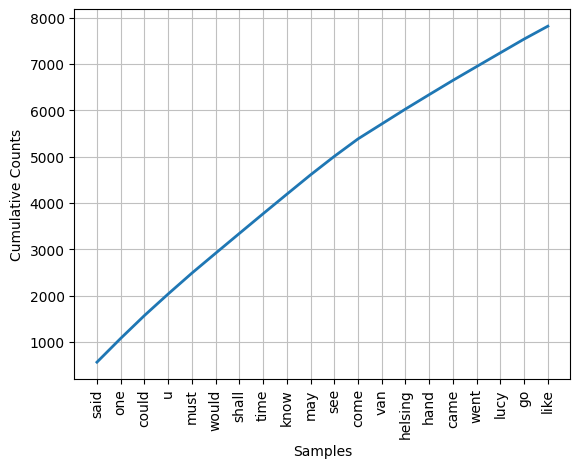

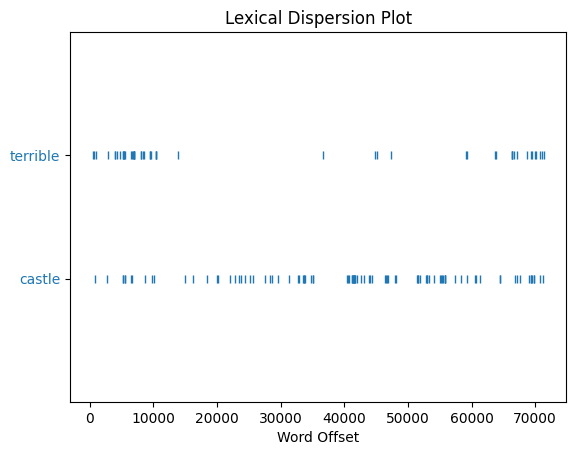

In [68]:
showcase_nltk(cache_read(Config.doc_path))

## Gensim

In [138]:
def show_available_gensim_corpora() -> pd.DataFrame:
    gensim_info = gensim.downloader.info()
    return pd.DataFrame(gensim_info["corpora"]).rename_axis(index="corpus").T


def show_pretrained_gensim_models() -> pd.DataFrame:
    gensim_info = gensim.downloader.info()
    return pd.DataFrame(gensim_info["models"]).rename_axis(index="model").T


def train_gensim_keyed_vectors(
    text: str,
    vector_size: int = 32,
    model="word2vec",
) -> gensim.models.KeyedVectors:
    sentences = nltk.tokenize.sent_tokenize(text)
    sentences = [tokenize(s) for s in sentences]

    match model:
        case "word2vec":
            model = gensim.models.Word2Vec(sentences=sentences, vector_size=vector_size)
        case "fasttext":
            model = gensim.models.FastText(
                sentences=sentences, vector_size=vector_size, epochs=10
            )
            model.build_vocab(corpus_iterable=sentences)
            model.train(
                corpus_iterable=sentences,
                total_examples=model.corpus_count,
                epochs=model.epochs,
            )

    keyed_vectors = model.wv
    return keyed_vectors

def extract_topics(documents: list[str], num_topics: int = 10) -> pd.DataFrame:
    documents = [tokenize(d) for d in documents]
    dictionary = gensim.corpora.Dictionary(documents=documents)
    corpus = [dictionary.doc2bow(d) for d in documents]
    dictionary[0]  # To 'load' dictionary, gensim implementation detail

    model = gensim.models.LdaModel(
        corpus=corpus, id2word=dictionary.id2token, num_topics=num_topics
    )

    topics = model.top_topics(corpus)
    topics = [[w for _, w in t[0]] for t in topics]

    return pd.DataFrame(topics).rename_axis(index="topics", columns="words")

def doesnt_match(keyed_vectors: gensim.models.KeyedVectors, n_choices: int = 6):
    center_word, doesnt_match_word = random.sample(keyed_vectors.index_to_key, 2)
    words = keyed_vectors.most_similar(center_word, topn=n_choices - 2)
    words = [i[0] for i in words]
    words.append(center_word)
    words.append(doesnt_match_word)
    random.shuffle(words)
    return {"choices": words, "doesnt_match": doesnt_match_word}

In [233]:
def showcase_gensim(text:str):
    keyed_vectors = train_gensim_keyed_vectors(text, model="fasttext")
    embedding = embed(keyed_vectors.vectors, model="umap")
    plot_with_annotations(
        x=embedding[:, 0],
        y=embedding[:, 1],
        annotations=keyed_vectors.index_to_key,
        title="Token embeddings",
    )
    IPython.display.display(extract_topics(documents=[text]))
    pprint.pprint(doesnt_match(keyed_vectors))

In [234]:
showcase_gensim(cache_read(Config.doc_path))

words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
topics,,,,,,,,,,,,,,,,,,,,
0,said,must,one,shall,u,may,see,time,would,could,know,came,come,hand,night,_,thing,lucy,day,went
1,u,one,said,come,time,may,night,would,helsing,must,see,hand,could,know,_,shall,van,back,well,good
2,could,u,one,said,shall,must,time,may,went,know,see,would,helsing,day,come,like,seemed,_,night,lucy
3,one,said,could,shall,may,u,must,night,time,would,see,know,go,way,_,van,went,thing,man,helsing
4,said,could,one,know,time,would,see,shall,went,u,come,go,came,van,lucy,must,hand,like,_,may
5,time,u,could,one,said,may,must,would,shall,night,van,come,helsing,see,know,lucy,even,back,day,go
6,said,could,would,one,must,know,u,come,_,see,may,van,time,shall,helsing,lucy,thing,like,good,back
7,must,could,said,would,may,one,time,know,helsing,see,shall,u,came,come,go,hand,_,van,lucy,back
8,know,said,one,must,u,may,shall,see,time,would,hand,come,night,go,room,like,day,van,helsing,back


{'doesnt_match': 'pride',
 'words': ['charge', 'eaten', 'immediate', 'rate', 'gate', 'pride']}


In [ ]:
# doesnt_match(keyed_vectors=gensim.downloader.load("fasttext-wiki-news-subwords-300"))

## [Spacy](https://spacy.io/api)

In [ ]:
!python -m spacy download en_core_web_sm -qqq

In [243]:
nlp = spacy.load("en_core_web_sm")

In [245]:
nlp?

In [301]:
# Spacy
# Write my own word2vec via pytorch (try torch.compile), lightning, annoy(faiss) libraries